In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

verbose_print = True

def log(*args, **kwargs):
    if verbose_print:
        print("LOG:", *args, **kwargs)

np.random.seed(42)

In [2]:
def load_csv(path):
    full = os.path.join('diabetes', path)
    return pd.read_csv(full)

df_immutable = load_csv('fav_ds.csv')


def features_response(df):
    return df.drop('readmitted', axis=1), df['readmitted']

def fresh_copy():
    return df_immutable.copy()

def fresh_dfs():
    return features_response(fresh_copy())
    
pd.set_option('display.max_columns', None)

print(df_immutable.info())
df_immutable.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7831 entries, 0 to 7830
Columns: 170 entries, age to readmitted
dtypes: float64(1), int64(168), object(1)
memory usage: 10.2+ MB
None


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,weight_present,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_25,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_17,admission_source_id_20,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_bamboozled,gender_Male,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Otolaryngology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-Endocrinology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiology,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-General,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Thoracic,medical_specialty_Urology,medical_specialty_bamboozled,diag_1_Congenital Anomalies,diag_1_Diseases of the Blood and Blood-forming Organs,diag_1_Diseases of the Circulatory System,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Nervous System and Sense Organs,diag_1_Diseases of the Respiratory System,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_1_Infectious and Parasitic Diseases,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_None,diag_1_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions",diag_2_Congenital Anomalies,diag_2_Diseases of the Blood and Blood-forming Organs,diag_2_Diseases of the Circulatory System,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Nervous System and Sense Organs,diag_2_Diseases of the Respiratory System,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_2_Infectious and Parasitic Diseases,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_None,diag_2_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions",diag_2_injury and poisoning,diag_3_Congenital Anomalies,diag_3_Diseases of the Blood and Blood-forming Organs,diag_3_Diseases of the Circulatory System,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Nervous System and Sense Organs,diag_3_Diseases of the Respiratory System,diag_3_Diseases of the Skin an

In [3]:
def fresh_dfs_bin():
    features, labels = features_response(fresh_copy())
    return features, ~(labels == 'NO')

In [4]:
def process_df(df, labels):
    # Split into train and test
    
    X_all, y_all = df.values, labels.values
    feature_names = df.columns

    X_all = StandardScaler().fit_transform(X_all)

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
    train_full_idx, test_idx = next(sss.split(X_all, y_all))

    X_train_full, y_train_full = X_all[train_full_idx], y_all[train_full_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    # Further split train into train and validation
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

    train_idx, dev_idx = next(sss.split(X_train_full, y_train_full))
    X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
    X_dev, y_dev = X_train_full[dev_idx], y_train_full[dev_idx]

    log(f"Shape of train: {X_train.shape}, {y_train.shape}")
    log(f"Shape of dev: {X_dev.shape}, {y_train.shape}")
    log(f"Shape of test: {X_test.shape}, {y_test.shape}")
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

def fresh_sets():
    df, labels = fresh_dfs()
    return process_df(df, labels)

def self_acc(model, X, y):
    log("Calculating accuracy on the test data...")
    model.fit(X, y)
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    
    log(f"Accuracy on the test data is {acc}")

def cv_acc(model, cv=5):
    
    X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()
    
    full_X = np.concatenate((X_train, X_test))
    full_y = np.concatenate((y_train, y_test))
    
    log(f"Model {model}")
    
    self_acc(model, full_X, full_y)
    
    start = time.time()
    acc = np.mean(cross_val_score(model, full_X, full_y, cv=cv))
    log(f"Cross val score: {acc}")
    
    elapsed = time.time() - start
    log(f"Mean elapsed for each cv: {elapsed/cv}\n")
    
    return acc

In [5]:
rf_fav = RandomForestClassifier(random_state=42, n_estimators=300, max_leaf_nodes=300, n_jobs=3)
cv_acc(rf_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=300,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.7737112599283601
LOG: Cross val score: 0.5355912767631268
LOG: Mean elapsed for each cv: 1.2926131248474122



0.5355912767631268

In [6]:
from sklearn.metrics import confusion_matrix

df_bin, df_labels_bin = fresh_dfs_bin()
df, df_labels = fresh_dfs()

X_train_bin, y_train_bin, X_dev_bin, y_dev_bin, X_test_bin ,y_test_bin = process_df(df_bin, df_labels_bin)
X_train, y_train, X_dev, y_dev, X_test, y_test = process_df(df, df_labels)

X_train_bin_full, y_train_bin_full = np.concatenate((X_train_bin, X_dev_bin)), np.concatenate((y_train_bin, y_dev_bin))
X_train_full, y_train_full = np.concatenate((X_train, X_dev)), np.concatenate((y_train, y_dev))


rf_fav.fit(X_train_bin_full, y_train_bin_full)
pred_bin = rf_fav.predict(X_test_bin)
pred_bin_probas = rf_fav.predict_proba(X_test_bin)

rf_fav.fit(X_train_full, y_train_full)
pred = rf_fav.predict(X_test)
pred_probas = rf_fav.predict_proba(X_test)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

print(classification_report(y_test_bin, pred_bin))
report = classification_report(y_test, pred, output_dict=True)

0.5663265306122449
              precision    recall  f1-score   support

         <30       0.68      0.54      0.60       233
         >30       0.52      0.47      0.49       262
          NO       0.54      0.68      0.60       289

    accuracy                           0.57       784
   macro avg       0.58      0.56      0.56       784
weighted avg       0.57      0.57      0.56       784

              precision    recall  f1-score   support

       False       0.64      0.35      0.45       289
        True       0.70      0.88      0.78       495

    accuracy                           0.69       784
   macro avg       0.67      0.62      0.61       784
weighted avg       0.68      0.69      0.66       784



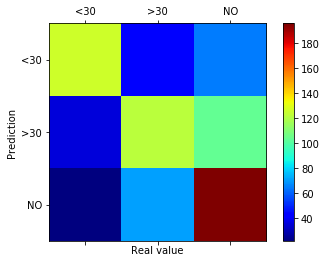

In [9]:
def conf_matrix(y, pred):
    labels = ['<30', '>30', 'NO']
    vals = confusion_matrix(y, pred, labels)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    fig.colorbar(ax.matshow(vals, cmap='jet'))
    
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    
    ax.set_xlabel('Real value')
    ax.set_ylabel('Prediction')
    
    return fig

conf_matrix(y_test, pred).savefig('conf-map.png')

In [10]:
print(pd.DataFrame(report).drop('support').drop(['accuracy', 'macro avg', 'weighted avg'], axis=1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &       <30 &       >30 &        NO \\
\midrule
precision &  0.684783 &  0.519149 &  0.536986 \\
recall    &  0.540773 &  0.465649 &  0.678201 \\
f1-score  &  0.604317 &  0.490946 &  0.599388 \\
\bottomrule
\end{tabular}



In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y, pred_probas, title):
    fpr, tpr, thresholds = roc_curve(y, pred_probas)
    auc = roc_auc_score(y, pred_probas)
    
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    
    plt.title(title + f' (auc={auc})')
    
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    
    return plt

In [13]:
def cool_roc_curve(feature_true):
    features, labels = features_response(fresh_copy())
    labels = (labels == feature_true)
    
    X_train, y_train, X_dev, y_dev, X_test, y_test = process_df(features, labels)
    X_train_full, y_train_full = np.concatenate((X_train, X_dev)), np.concatenate((y_train, y_dev))
    
    rf_fav.fit(X_train_full, y_train_full)
    pred_proba = rf_fav.predict_proba(X_test)[:, 1]
    
    return plot_roc_curve(y_test, pred_proba, f'ROC for feature {feature_true}')

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


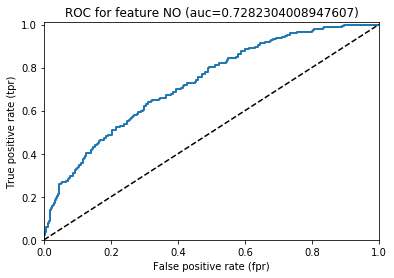

In [14]:
cool_roc_curve('NO').savefig('roc-auc-no.png')

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


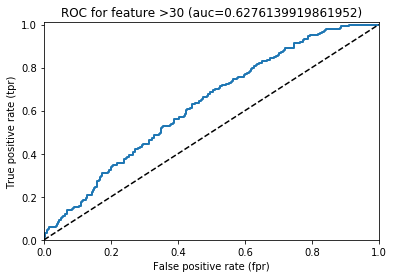

In [15]:
cool_roc_curve('>30').savefig('roc-auc-g30.png')

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


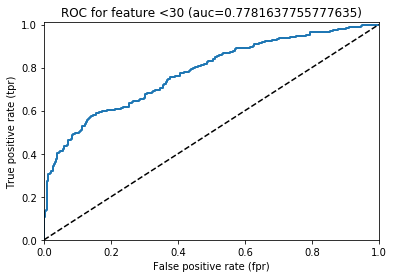

In [16]:
cool_roc_curve('<30').savefig('roc-auc-l30.png')